In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy import ndimage, misc
from skimage.morphology import skeletonize
import sklearn
from sklearn import linear_model
from sklearn import model_selection 
from tqdm import tqdm
import cv2
import tifffile
import cupy as cp
import matplotlib
from cupyx.scipy import ndimage
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
import random


# simulated annealling

In [16]:
def extract_features(image, sigma):
    #np.warnings.filterwarnings('error', category=np.VisibleDeprecationWarning)
    
    mempool = cp.get_default_memory_pool()
    pinned_mempool = cp.get_default_pinned_memory_pool()
    im_8=np.uint8(im)

    #gray = cv2.cvtColor(im_8, cv2.COLOR_BGR2GRAY)
    # Find Canny edges
    edged = cv2.Canny(im_8, 30, 200)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    im_blur = ndimage.gaussian_filter(cp.array(im), sigma=sigma, mode='constant',cval=0)
    
    im_blur_norm=im_blur*sigma*cp.sqrt(np.pi)

    im_sx = ndimage.sobel(im_blur_norm, axis=1, mode='reflect')
    im_sy = ndimage.sobel(im_blur_norm, axis=0, mode='reflect')
    im_sobel=np.hypot(im_sx, im_sy)

    centroids = []
    feats = []
  
    #im_lap = ndimage.gaussian_laplace(im, sigma=sigma, mode='reflect')
   
    for jj in range(len(contours)):    
     
        im_zer = np.zeros((im.shape[0],im.shape[1]) ) # create a single channel 200x200 pixel black image 
        filled_array = cv2.fillPoly(im_zer, pts =[contours[jj]], color=(255))
        obj = np.argwhere(filled_array == 255)
        #number_mat[ii,jj]=number

        density = cp.nanmean(im_blur_norm[obj[:,0],obj[:,1]])
        grad = cp.nanmean(im_sobel[obj[:,0],obj[:,1]])
        #lap=np.nanmean(im_lap[obj[:,0],obj[:,1]])
        
        """M = cv2.moments(contours[jj])
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        print()
        centroids.append(np.array([cX,cY]).reshape(-1,2))"""
        feats.append([density.get(), grad.get()])

    mempool.free_all_blocks()
    pinned_mempool.free_all_blocks()

    feats = np.array(feats)

    return feats

In [17]:
def generate_window(window_size, p, local_radius):
    random_pattern = np.random.rand(window_size, window_size)
    binary_pattern = np.where(random_pattern < p, 1, 0)

    org_locs = np.argwhere(binary_pattern == 1)

    org_locs_scaled = org_locs*200+25+local_radius
    pattern_dim_scaled = window_size*200+25+2*local_radius
    
    centroids = []
    im = np.zeros((pattern_dim_scaled, pattern_dim_scaled))

    for y, x in org_locs_scaled:
        im[y:y+150,x:x+150] = 255
        centroids.append((y+75, x+75))
    
    return im, centroids

In [11]:

def move(nx, ny, centers, ix, image):
    plt.imshow(image)
    plt.show()
    
    # make new one
    img = np.copy(image)
    test_centers = centers.copy()
    
    old_x, old_y = test_centers[ix]
    img[old_x-75: old_x+75, old_y-75:old_y+75] = 0
    img[nx-75:nx+75, ny-75:ny+75] = 255
    centers[ix] = (nx, ny)
    plt.imshow(img)
    plt.show()
    print("##############")
    return img, centers

def validate(cx, cy, centroids):
    rep = np.tile(np.array([cx, cy]).reshape(-1,2), [len(centroids), 1])
    centroids_arr = np.array(centroids)
    dist = np.sqrt(np.sum((rep-centroids_arr)**2, axis = 1))
    valid = np.all(dist > 200)
    return valid

def evaluate(im):
    feats400 = extract_features(im, 400)
    feats800 = extract_features(im, 800)
    
    if len(feats800) > 0 and len(feats400) > 0:
        density = feats800[:, 0]
        grad = feats400[:, 1]
        newX = np.hstack((density, grad)).reshape(-1, 2)
        newXScaled = scaler.transform(newX)
        preds = rbf_svc.predict(newXScaled)
        pred_mean = np.mean(preds)
    return pred_mean
        
    
def simulate(nx, ny, old_centers, ix, image):
    test_im, new_centers = move(nx, ny, old_centers, ix, image)
    new_score = evaluate(test_im)
    return test_im, new_centers, new_score

def random_move(centers):
    random_index = random.randint(0,len(centroids)-1)

    dx, dy = np.random.normal(0, 100, 2)
    dx, dy = np.rint(dx), np.rint(dy)

    newx, newy = int(centers[random_index][0] + dx), int(centers[random_index][1] + dy)

    nbors = centers[:random_index] + centers[random_index+1:]
    
    if validate(newx, newy, nbors):
        print(newx, newy)
        return newx, newy, random_index
    else:
        return random_move(centers)

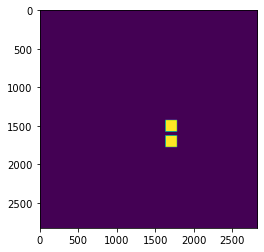

1762 1672


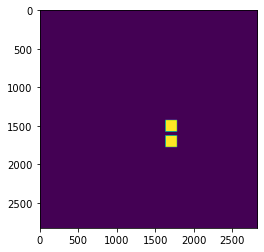

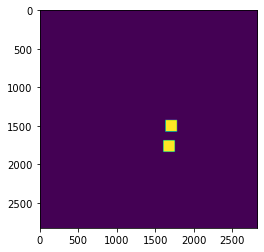

##############
Rejected: New score 0.18 <= old score 0.18
1548 1749


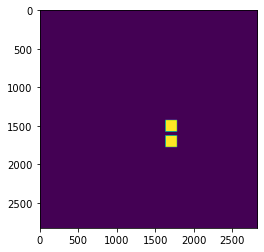

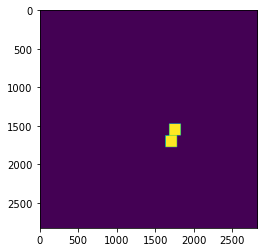

##############
Rejected: New score 0.18 <= old score 0.18
1808 1762


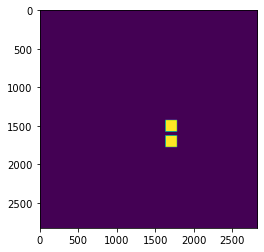

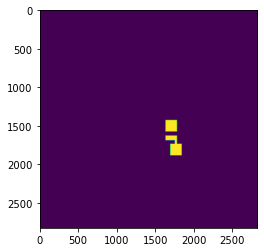

##############
Rejected: New score 0.18 <= old score 0.18
1776 1649


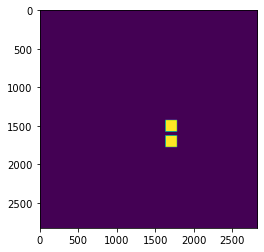

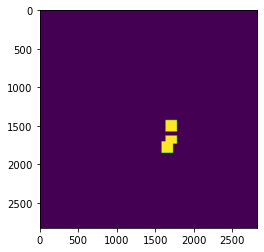

##############
Rejected: New score 0.18 <= old score 0.18
1437 1568


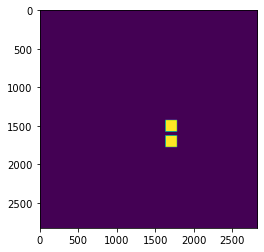

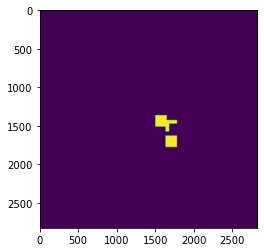

##############
Rejected: New score 0.18 <= old score 0.18
1280 1645


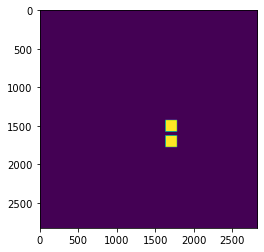

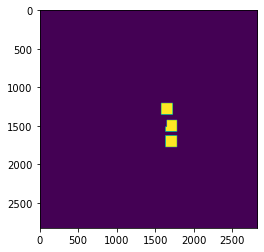

##############
Rejected: New score 0.18 <= old score 0.18
1766 1764


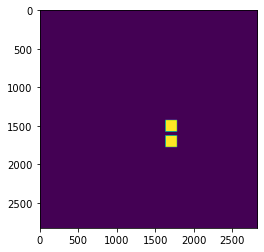

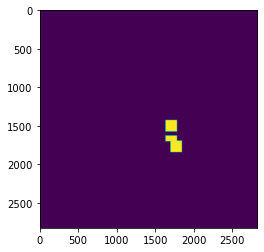

##############
Rejected: New score 0.18 <= old score 0.18
1223 1819


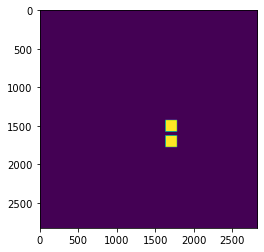

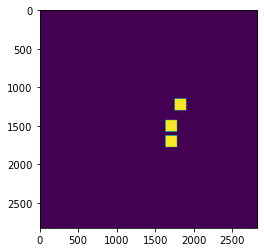

##############
Rejected: New score 0.18 <= old score 0.18


KeyboardInterrupt: 

In [7]:
im, centroids = generate_window(4, .3, 1000)
# check if there is more than one centroid
plt.imshow(im)
plt.show()

epsilon = 0
dfHeitorRandom = pd.read_csv("random_features_dipole.csv")
rX, ry = dfHeitorRandom.iloc[:, :-1], dfHeitorRandom.iloc[:, -1]
rxSub = rX[["density_800", "grad_400"]]
scaler = StandardScaler()
rxSubScale = scaler.fit_transform(rxSub)
x, y = rxSubScale[:, 0], rxSubScale[:, 1]
rbf_svc = SVR(kernel='rbf').fit(rxSubScale, ry.ravel())

for _ in range(10):
    curr_score = evaluate(im)
    
    newx, newy, random_index = random_move(centroids)
    
    """if np.random.uniform() < .1:
        print("Random Perturbation")
        im, new_centroids = move(newx, newy, centroids, random_index, im)
        centroids = new_centroids
    else:"""
    new_im, new_centroids, new_score  = simulate(newx, newy, centroids, random_index, im)
    if new_score - curr_score > epsilon:
        print("Accepted: New score %.2f > old score %.2f" % (new_score, curr_score))
        im, centroids, curr_score = new_im, new_centroids, new_score
    else:
        print("Rejected: New score %.2f <= old score %.2f" % (new_score, curr_score))
                
plt.imshow(im)
plt.show()

# Other

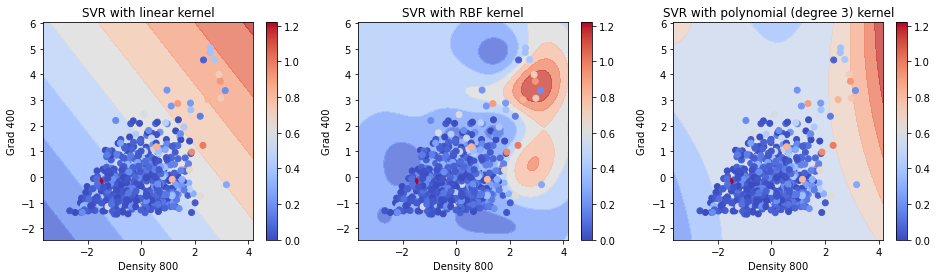

In [181]:
dfHeitorRandom = pd.read_csv("random_features_dipole.csv")
rX, ry = dfHeitorRandom.iloc[:, :-1], dfHeitorRandom.iloc[:, -1]
rxSub = rX[["density_800", "grad_400"]]
scaler = StandardScaler()
rxSubScale = scaler.fit_transform(rxSub)
x, y = rxSubScale[:, 0], rxSubScale[:, 1]

svc = SVR(kernel='linear').fit(rxSubScale, ry.ravel())
rbf_svc = SVR(kernel='rbf').fit(rxSubScale, ry.ravel())
poly_svc = SVR(kernel='poly').fit(rxSubScale, ry.ravel())
sig_svc = SVR(kernel='sigmoid').fit(rxSubScale, ry.ravel())


h = .01
x_min, x_max = x.min() - 1, x.max() + 1
y_min, y_max = y.min() - 1, y.max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

titles = ['SVR with linear kernel',
          'SVR with RBF kernel',
          'SVR with polynomial (degree 3) kernel',
          'SVR with sigmoid kernel']

plt.figure(figsize=(16,4))
for i, regr in enumerate((svc, rbf_svc, poly_svc)):
    plt.subplot(1, 3, i + 1)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    
    Z = regr.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(x, y, c=ry.ravel(), cmap=plt.cm.coolwarm)
    plt.xlabel('Density 800')
    plt.ylabel('Grad 400')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.colorbar()
    plt.title(titles[i])

plt.show()

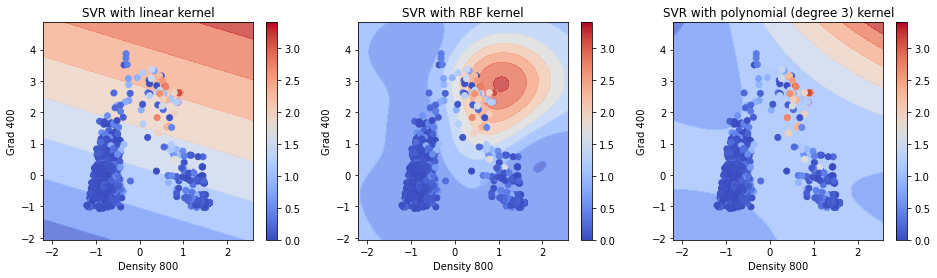

In [3]:
bX = pd.read_csv("dfXFilterHeitor.csv")

by = pd.read_csv("dfyFilterHeitor.csv").values

bxSub = bX[["density_800", "grad_400"]]
scaler = StandardScaler()
bxSubScale = scaler.fit_transform(bxSub)

x, y, z = bxSubScale[:, 0], bxSubScale[:, 1], by

svc = SVR(kernel='linear').fit(bxSubScale, by.ravel())
rbf_svc = SVR(kernel='rbf').fit(bxSubScale, by.ravel())
poly_svc = SVR(kernel='poly').fit(bxSubScale, by.ravel())
sig_svc = SVR(kernel='sigmoid').fit(bxSubScale, by.ravel())


h = .01
x_min, x_max = x.min() - 1, x.max() + 1
y_min, y_max = y.min() - 1, y.max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

titles = ['SVR with linear kernel',
          'SVR with RBF kernel',
          'SVR with polynomial (degree 3) kernel',
          'SVR with sigmoid kernel']

plt.figure(figsize=(16,4))
for i, regr in enumerate((svc, rbf_svc, poly_svc)):
    plt.subplot(1, 3, i + 1)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    
    Z = regr.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(x, y, c=by.ravel(), cmap=plt.cm.coolwarm)
    plt.xlabel('Density 800')
    plt.ylabel('Grad 400')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.colorbar()
    plt.title(titles[i])

plt.show()

# Generate Patterns

In [4]:
pattern_dim = 40
threshold = 1/16

def generate_pattern(pattern_dim, threshold, seed):
    np.random.seed(seed)
    random_pattern = np.random.rand(pattern_dim, pattern_dim)
    binary_pattern = np.where(random_pattern < threshold, 1, 0)

    org_locs = np.argwhere(binary_pattern == 1)

    org_locs_scaled = org_locs*200+25
    centroids = []
    im = np.zeros((8000, 8000))

    for y, x in org_locs_scaled:
        im[y:y+150,x:x+150] = 255
        centroids.append((y+75, x+75))
    
    return im, centroids

im, centroids = generate_pattern(pattern_dim, threshold, 3)

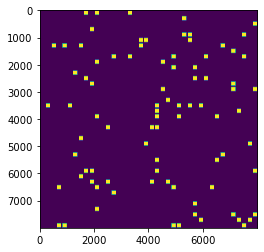

In [18]:
plt.imshow(im)

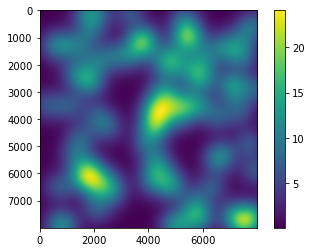

In [67]:
feats = extract_features(im, 400)

(array([10.,  6., 17., 17.,  8.,  8.,  6.,  7.,  4.,  3.]),
 array([ 4143.19352011,  5376.8016632 ,  6610.40980629,  7844.01794938,
         9077.62609247, 10311.23423557, 11544.84237866, 12778.45052175,
        14012.05866484, 15245.66680793, 16479.27495102]),
 <BarContainer object of 10 artists>)

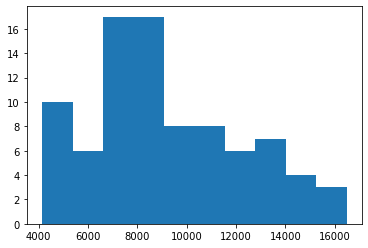

In [68]:
plt.hist(feats[:, 0])

(array([13., 11., 13., 13., 12.,  5.,  7.,  4.,  5.,  3.]),
 array([ 12.74164118,  25.13870618,  37.53577119,  49.9328362 ,
         62.32990121,  74.72696621,  87.12403122,  99.52109623,
        111.91816124, 124.31522624, 136.71229125]),
 <BarContainer object of 10 artists>)

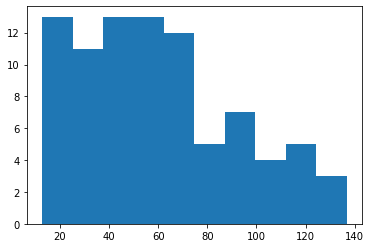

In [71]:
plt.hist(feats[:, 1])

In [4]:
dfHeitorRandom = pd.read_csv("random_features_dipole.csv")
rX, ry = dfHeitorRandom.iloc[:, :-1], dfHeitorRandom.iloc[:, -1]
rxSub = rX[["density_800", "grad_400"]]
scaler = StandardScaler()
rxSubScale = scaler.fit_transform(rxSub)
x, y = rxSubScale[:, 0], rxSubScale[:, 1]

#svc = SVR(kernel='linear').fit(rxSubScale, ry.ravel())
rbf_svc = SVR(kernel='rbf').fit(rxSubScale, ry.ravel())

(array([394.,  92.,  29.,  27.,   9.,   4.,   7.,   3.,   2.,   1.]),
 array([0.        , 0.12185011, 0.24370022, 0.36555034, 0.48740045,
        0.60925056, 0.73110067, 0.85295078, 0.9748009 , 1.09665101,
        1.21850112]),
 <BarContainer object of 10 artists>)

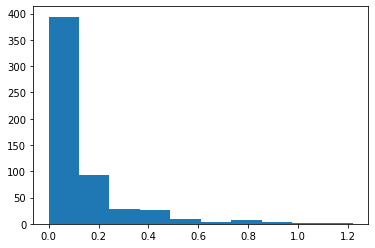

In [5]:
plt.hist(ry.ravel())

(array([  9.,  25.,  71., 109., 132., 109.,  70.,  30.,   7.,   6.]),
 array([-2.66731628, -2.08249791, -1.49767955, -0.91286118, -0.32804281,
         0.25677556,  0.84159392,  1.42641229,  2.01123066,  2.59604902,
         3.18086739]),
 <BarContainer object of 10 artists>)

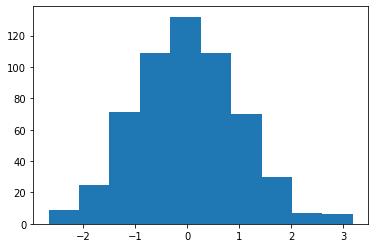

In [6]:
plt.hist(rxSubScale[:, 0])

(array([117., 174., 142.,  73.,  34.,  14.,   6.,   3.,   1.,   4.]),
 array([-1.44167865, -0.79410461, -0.14653057,  0.50104347,  1.1486175 ,
         1.79619154,  2.44376558,  3.09133962,  3.73891365,  4.38648769,
         5.03406173]),
 <BarContainer object of 10 artists>)

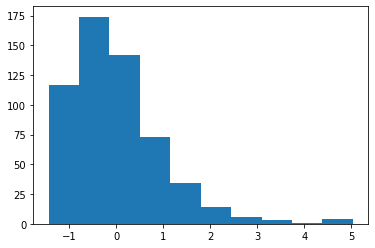

In [7]:
plt.hist(rxSubScale[:, 1])

(array([491.,  46.,  13.,  10.,   2.,   1.,   0.,   1.,   1.,   3.]),
 array([0.08470381, 0.14426886, 0.20383391, 0.26339897, 0.32296402,
        0.38252907, 0.44209412, 0.50165917, 0.56122422, 0.62078927,
        0.68035433]),
 <BarContainer object of 10 artists>)

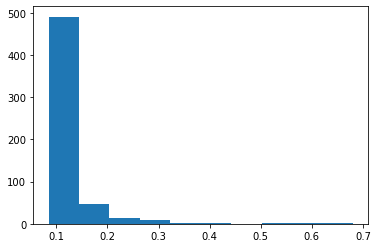

In [8]:
plt.hist(rbf_svc.predict(rxSubScale))

In [12]:
good_points = rxSubScale[rbf_svc.predict(rxSubScale) > 0.5]

In [13]:
good_points

array([[2.94854468, 3.7357674 ],
       [2.96854978, 3.07451646],
       [3.13629788, 3.37176038],
       [2.90295508, 3.99556773],
       [2.49122656, 3.01609379]])

In [88]:
im, centroids = generate_window(3, 0.5, 1000)

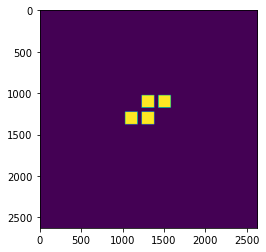

In [89]:
plt.imshow(im)

In [2]:
def extract_features(image, sigma):
    im = image.copy()
    mempool = cp.get_default_memory_pool()
    pinned_mempool = cp.get_default_pinned_memory_pool()
    im_8=np.uint8(im)
    #gray = cv2.cvtColor(im_8, cv2.COLOR_BGR2GRAY)
    # Find Canny edges
    edged = cv2.Canny(im_8, 30, 200)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    im_blur = ndimage.gaussian_filter(cp.array(im), sigma=sigma, mode='constant',cval=0)
    
    im_blur_norm=im_blur*sigma*cp.sqrt(np.pi)
    
    im_sx = ndimage.sobel(im_blur_norm, axis=1, mode='reflect')
    im_sy = ndimage.sobel(im_blur_norm, axis=0, mode='reflect')
    im_sobel=np.hypot(im_sx, im_sy)
    
    centroids = []
    feats = []
    #im_lap = ndimage.gaussian_laplace(im, sigma=sigma, mode='reflect')
    for jj in range(np.shape(contours)[0]):            
        im_zer = np.zeros( (im.shape[0],im.shape[1]) ) # create a single channel 200x200 pixel black image 
        filled_array = cv2.fillPoly(im_zer, pts =[contours[jj]], color=(255))
        obj = np.argwhere(filled_array == 255)
        #number_mat[ii,jj]=number

        density=cp.nanmean(im_blur_norm[obj[:,0],obj[:,1]])
        grad=cp.nanmean(im_sobel[obj[:,0],obj[:,1]])
        #lap=np.nanmean(im_lap[obj[:,0],obj[:,1]])
        
        M = cv2.moments(contours[jj])
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroids.append(np.array([cX,cY]).reshape(-1,2))
        feats.append([density.get(), grad.get()])

    mempool.free_all_blocks()
    pinned_mempool.free_all_blocks()
    return np.array(feats)

In [3]:
def generate_window(window_size, p, local_radius):
    random_pattern = np.random.rand(window_size, window_size)
    binary_pattern = np.where(random_pattern < p, 1, 0)

    org_locs = np.argwhere(binary_pattern == 1)

    org_locs_scaled = org_locs*200+25+local_radius
    pattern_dim_scaled = window_size*200+25+2*local_radius
    
    centroids = []
    im = np.zeros((pattern_dim_scaled, pattern_dim_scaled))

    for y, x in org_locs_scaled:
        im[y:y+150,x:x+150] = 255
        centroids.append((y+75, x+75))
    
    return im, centroids

In [4]:
dfHeitorRandom = pd.read_csv("random_features_dipole.csv")
rX, ry = dfHeitorRandom.iloc[:, :-1], dfHeitorRandom.iloc[:, -1]
rxSub = rX[["density_800", "grad_400"]]
scaler = StandardScaler()
rxSubScale = scaler.fit_transform(rxSub)
x, y = rxSubScale[:, 0], rxSubScale[:, 1]
rbf_svc = SVR(kernel='rbf').fit(rxSubScale, ry.ravel())

windows = list(range(5, 9))
ps = np.linspace(0.1,.4, 5)

best_designs = []
for _ in tqdm(range(10)):
    for window in windows:
        for p in ps:
            im, centroids = generate_window(window, p, 1025)
            plt.show()
            if len(feats800) > 0 and len(feats400) > 0:
                density = feats800[:, 0]
                grad = feats400[:, 1]
                newX = np.hstack((density, grad)).reshape(-1, 2)
                newXScaled = scaler.transform(newX)
                preds = rbf_svc.predict(newXScaled)
                pred_min = np.min(preds)
                pred_mean = np.mean(preds)
                pred_max = np.max(preds)
                best_designs.append([im, window, p, newXScaled, pred_min, pred_mean, pred_max])
        
        

  0%|                                                                                                                       | 0/10 [00:00<?, ?it/s]


NameError: name 'feats800' is not defined

In [ ]:
dfHeitorRandom = pd.read_csv("random_features_dipole.csv")
rX, ry = dfHeitorRandom.iloc[:, :-1], dfHeitorRandom.iloc[:, -1]
rxSub = rX[["density_800", "grad_400"]]
scaler = StandardScaler()
rxSubScale = scaler.fit_transform(rxSub)
x, y = rxSubScale[:, 0], rxSubScale[:, 1]
rbf_svc = SVR(kernel='rbf').fit(rxSubScale, ry.ravel())

windows = list(range(5, 9))
ps = np.linspace(0.1,.4, 5)

best_designs = []
for _ in tqdm(range(100)):
    im, centroids = generate_window(8, .3, 25)
    plt.show()
    feats800 = extract_features(im, 800)
    feats400 = extract_features(im, 400)
    if len(feats800) > 0 and len(feats400) > 0:
        density = feats800[:, 0]
        grad = feats400[:, 1]
        newX = np.hstack((density, grad)).reshape(-1, 2)
        newXScaled = scaler.transform(newX)
        preds = rbf_svc.predict(newXScaled)
        pred_min = np.min(preds)
        pred_mean = np.mean(preds)
        pred_max = np.max(preds)
        best_designs.append([im, c, newXScaled, pred_min, pred_mean, pred_max])
        
        